<div align='center'><font size="5" color='#353B47'>Stock Price Prediction Using LSTM Neural Networks</font></div>
<div align='center'><font size="4" color="#353B47"></font></div>
<br>
<hr>

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">Import data</a></font>**
**<br><font size="2"><a href="#chap2">Representation</a></font>**
**<br><font size="2"><a href="#chap3">Missing data</a></font>**
**<br><font size="2"><a href="#chap4">Seasonality</a></font>**
**<br><font size="2"><a href="#chap5">Time series components</a></font>**
**<br><font size="2"><a href="#chap6">Autocorrelation</a></font>**
**<br><font size="2"><a href="#chap7">Lag Scatter Plot</a></font>**
**<br><font size="2"><a href="#chap8">Moving Average</a></font>**
**<br><font size="2"><a href="#chap9">Exponential Smoothing</a></font>**
**<br><font size="2"><a href="#chap10">Preprocessing</a></font>**
**<br><font size="2"><a href="#chap11">LSTM Model</a></font>**
**<br><font size="2"><a href="#chap12">Training</a></font>**
**<br><font size="2"><a href="#chap13">Prediction</a></font>**

<div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Setup</h1></div>

In [83]:
!pip install pmdarima

In [28]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

<div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Import data</h1></div>

In [29]:
# Importing data and selecting specific columns
data = pd.read_csv(
    '..\lstm\preprocessed_CAC40.csv', 
    usecols = ['Name','Date','Open','Closing_Price','Daily_High','Daily_Low','Volume']
)

# Filtering the dataframe to focus on Air Liquide stocks
air_liquide = data[data['Name'] == 'Air Liquide'].copy()

# Converting the 'Date' column to a datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])

# Extracting year and month from the 'Date' column and adding them as separate columns
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

# Printing the shape of the 'air_liquide' dataframe
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 2600 rows, 9 columns


In [30]:
air_liquide.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Year,Month
2599,Air Liquide,2020-04-02,116.00,112.95,116.00,110.00,331,2020,4
2600,Air Liquide,2020-04-01,115.95,114.05,115.95,112.30,480,2020,4
2601,Air Liquide,2020-03-31,113.90,114.60,115.35,112.95,784,2020,3
2602,Air Liquide,2020-03-30,110.25,112.15,112.70,106.90,485,2020,3
2603,Air Liquide,2020-03-27,110.20,107.00,110.20,105.80,525,2020,3


<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Representation</h1></div>

A **line plot** represents a graphical method that showcases data as individual points or check marks positioned along a numerical axis, illustrating the frequency of each value. This type of visualization assists in identifying:

* **Outliers** or extreme values
* **Missing observations** (typically accompanied by error messages)
* **Data variability**
* **Seasonal patterns and trends** within the data

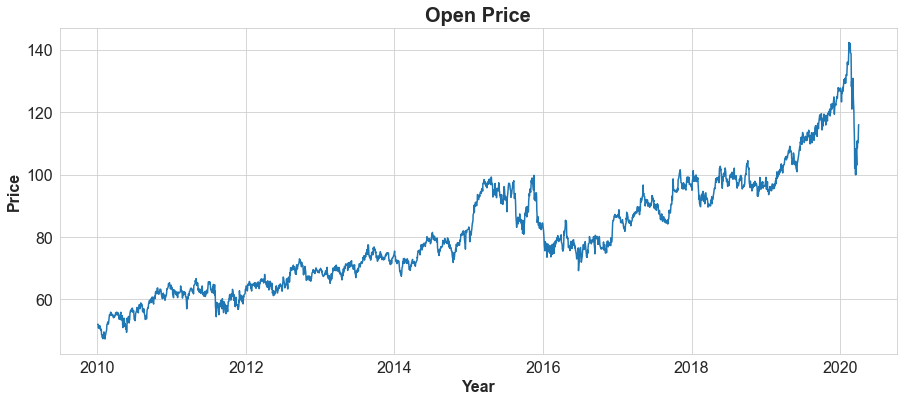

In [31]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide['Date'], air_liquide['Open'] )

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Adjusting tick label sizes for better readability
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

**<font color="#5963ab" size="4">Regarding Air Liquide stocks ?</font>**

The data does not appear to exhibit any discernible seasonality within each year. Instead, it demonstrates a trend as opposed to cyclical behavior. A notable decrease in price can be observed in early 2020, attributable to the COVID-19 pandemic.

<div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Missing data</h1></div>

In most instances, addressing missing data requires a case-by-case approach. Several methods can be employed to impute missing values:

* **Forward Fill and Backward Fill**: Forward filling entails replacing missing values with the preceding data point, while backward filling involves filling in missing values with the subsequent data point.
* **Linear Interpolation**: This technique involves using linear polynomials to estimate new data points within the scope of a discrete set of existing data points.
* **Quadratic Interpolation**: This method utilizes non-linear polynomials to estimate new data points within the range of a discrete set of known data points.
* **Mean of Nearest Neighbors**
* **Mean of Seasonal**

In [32]:
# Check the number of NaN values in each column of the dataframe
air_liquide.isna().sum()

Name               0
Date               0
Open               1
Closing_Price      0
Daily_High         0
Daily_Low          0
Volume           134
Year               0
Month              0
dtype: int64

There is one missing value in <font color='red'>'Open'</font> column and 134 misising values in <font color='red'>'Volume'</font> column

In [33]:
# Retrieve the index of the missing value in the 'Open' column
index_open_missing = air_liquide[pd.isnull(air_liquide['Open'])].index
print("index of the missing value in the Open column:", list(index_open_missing)[0])

index of the missing value in the Open column: 4538


In [34]:
# Replace the missing value in the 'Open' column with the value from the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

# Calculate and print the percentage of missing values in the 'Volume' column
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

Percentage of missing values in Volume: 0.05

Empty DataFrame
Columns: [Name, Date, Open, Closing_Price, Daily_High, Daily_Low, Volume, Year, Month]
Index: []


>Missing values in the <font color='red'>'Volume'</font> column account for 5% of the observations. Additionally, no instances of a zero value are present. It is reasonable to assume that a missing value signifies a trading volume of zero stocks for that particular observation.

In [35]:
# Missing values in the 'Volume' column are replaced by 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
air_liquide_plus = imputer.fit_transform(air_liquide)

# Imputation removed column names; put them back
imputed_air_liquide = pd.DataFrame(air_liquide_plus)

# Create a new dataframe with imputed values
imputed_air_liquide.columns = air_liquide.columns

In [36]:
# Replace comma by period so Volume can be converted to float
imputed_air_liquide['Volume'] = imputed_air_liquide['Volume'].apply(lambda x : str(x))
imputed_air_liquide['Volume'] = pd.to_numeric(imputed_air_liquide['Volume'].apply(lambda x : x.replace(',','',1)))

# Convert object type columns to numeric 
imputed_air_liquide['Open'] = pd.to_numeric(imputed_air_liquide['Open'])
imputed_air_liquide['Closing_Price'] = pd.to_numeric(imputed_air_liquide['Closing_Price'])
imputed_air_liquide['Daily_High'] = pd.to_numeric(imputed_air_liquide['Daily_High'])
imputed_air_liquide['Daily_Low'] = pd.to_numeric(imputed_air_liquide['Daily_Low'])

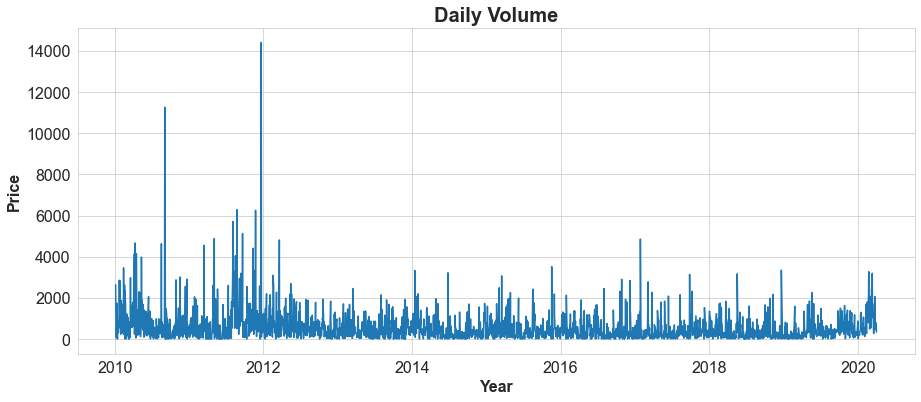

In [37]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(imputed_air_liquide['Date'], imputed_air_liquide['Volume'] )

# Formatting
ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

>The graph exhibits significant noise due to the use of a daily scale. By opting for the mean trading volume per month, rather than the daily trading volume, the resulting visualization is expected to be more comprehensible and visually appealing.

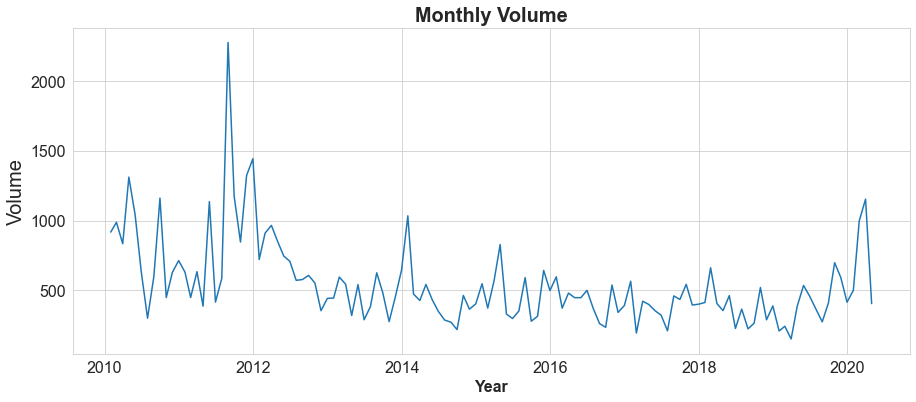

In [38]:
# Create a copy of the 'Date' and 'Volume' columns
y = imputed_air_liquide[['Date','Volume']].copy()

# Set the index to 'Date' and convert it to datetime format
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)

# Resample the time series to monthly and compute the mean of each month
y = y.resample('1M').mean()

# Add the 'Date' column back to the DataFrame
y['Date'] = y.index

# Plot the monthly volume time series
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(y['Date'], y['Volume'] )

# Set the title and axes labels
ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

Although the graph remains somewhat noisy, it is now more interpretable. The optimal period interval must be chosen to strike a balance between readability and the preservation of information.

* **Short period interval**: <font color='red'>Noisy signal</font>, <font color='green'>richer information</font>
* **Long period interval**: <font color='green'>Easily understandable signal</font>, <font color='red'>reduced information</font>

<div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Seasonality</h1></div>

**<font color="#5963ab" size="4">What is seasonality ?</font>**

>In Time Series data, seasonality is the presence of variations that **occur** at **specific regular intervals less than a year**, such as **weekly**, **monthly**, or **quarterly**.

In [39]:
imputed_air_liquide['Year'] = imputed_air_liquide['Date'].dt.year
imputed_air_liquide['Month'] = imputed_air_liquide['Date'].dt.month

In [40]:
print(imputed_air_liquide['Year'].unique())

[2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]


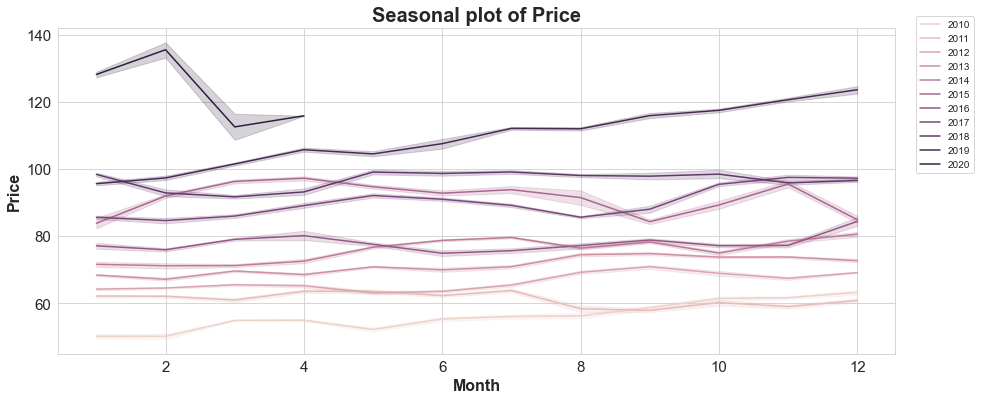

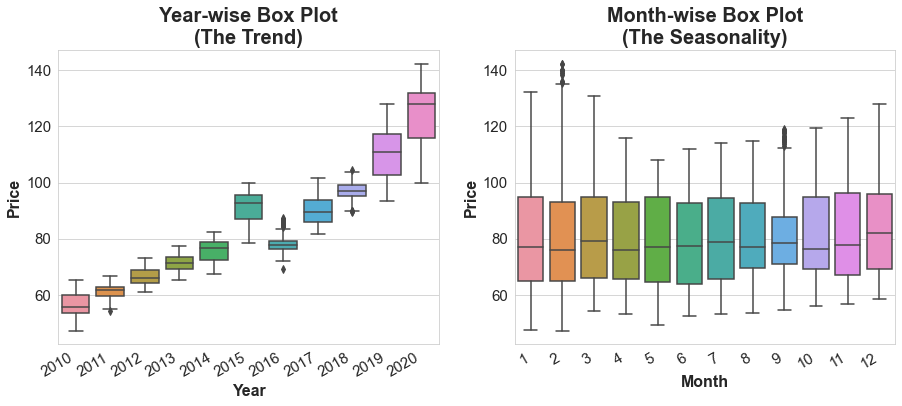

In [41]:
# Set the variable to plot
variable = 'Open'

# Create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the seasonal line plot
sns.lineplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])

# Format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

# Create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot the year-wise box plot
sns.boxplot(imputed_air_liquide['Year'], imputed_air_liquide[variable], ax=ax[0])

# Format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Plot the month-wise box plot
sns.boxplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], ax=ax[1])

# Format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Price**

>It is immediately evident that 2019 was a highly successful year for the company, with the share price surging from 95 euros to 125 euros. This constitutes the most significant increase within the past decade.

**Year wise Box Plot**

>A limited number of outliers, an absence of seasonality, and a general uptrend over the last ten years can be observed, with the exception of 2016. This minor deceleration is associated with the completion of the Airgas acquisition in 2016 and its inaugural contribution to the Group's performance. The full 2016 report can be accessed <a href='https://www.airliquide.com/sites/airliquide.com/files/2016/07/29/air-liquide-h1-2016-results.pdf'>here</a>.

**Month wise Box Plot**

>The minimal variance between each category highlights the lack of seasonality, as no discernible seasonal effect is present.

<font color='#5963ab' size='4'>An Effective Visualization</font>

<br>Overall, these plots enable you to:

* Assess the presence of seasonal patterns, if any
* Determine the years during which the pattern shifts
* Identify significant increases or decreases

In the trend and seasonality boxplot:

* Instantly examine trends and seasonality
* Identify outliers

Text(0, 0.5, 'Closing_Price')

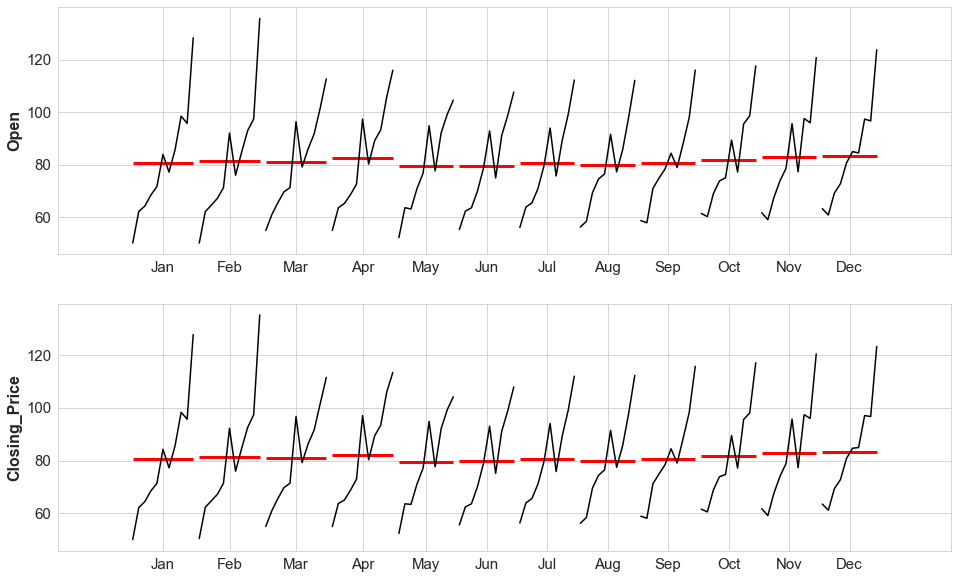

In [42]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open','Closing_Price']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['Closing_Price'], ax=ax[1]);
ax[1].set_ylabel('Closing_Price', fontsize = 16, fontdict=dict(weight='bold'))

>This graph employs a groupby function to provide a clearer view of potential monthly seasonality. It becomes evident that no seasonality is present. The 10-year average of Air Liquide's opening and closing prices per month remains relatively consistent.

<div id="chap5"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Time Series components</h1></div>

If we assume an additive decomposition, then we can write

$$y_t = S_t + T_t + R_t$$

where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component and $R_t$ is the residual component, all at period $t$.
Also,for a multiplicative decomposition, we have

$$y_t = S_t * T_t * R_t$$

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.


Text(0.5, 0.98, 'Open decomposition')

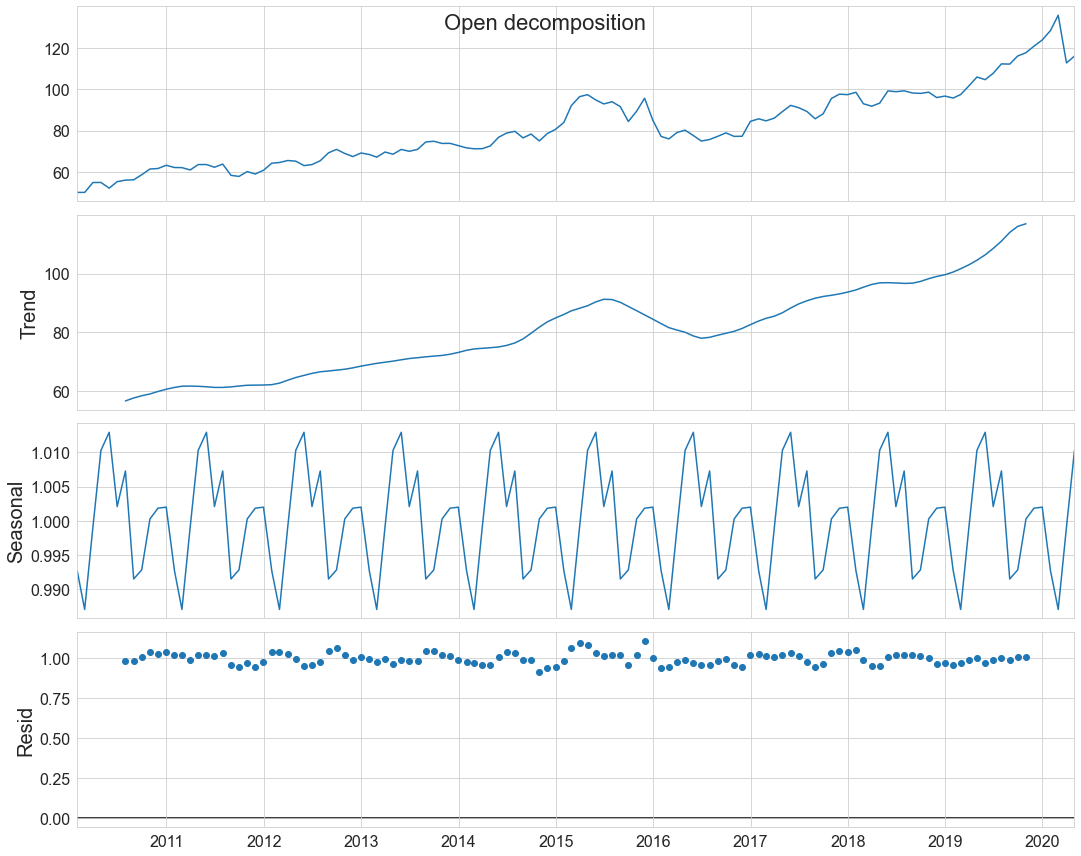

In [43]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date', 'Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams for plot size and font size
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library to perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

# Plotting the decomposition
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

<font color='#5963ab' size='4'>Interpreting the Visualization</font>

>The three components are individually displayed in the bottom three panels. By multiplying these components together, the data presented in the >top panel can be reconstructed. It is evident that the seasonal component changes gradually over time. However, this does not imply that years >further apart will not exhibit distinct seasonal patterns.
>
>The residual component depicted in the bottom panel represents the remaining values after subtracting the seasonal and trend-cycle components from >the data.
>
>When the seasonal component is removed from the original data, the resulting values constitute the "seasonally adjusted" data. In the case of >additive decomposition, the seasonally adjusted data are obtained using $y_t - S_t$, while for multiplicative data, the seasonally adjusted values >are calculated using $y_t / S_t$.

<div id="chap7"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Autocorrelation</h1></div>

<font color='#5963ab' size='4'>Differentiating Correlation, Autocorrelation, and Partial Autocorrelation</font>

<br>**Correlation** quantifies the degree of a linear relationship between two variables.

**Autocorrelation** evaluates the linear relationship between lagged values of a time series, such as between $y_t$ and $y_{t-1}$. A significant autocorrelation implies that previous values of the series (lags) could be useful in predicting the current value.

**Partial autocorrelations** assess the linear dependence of one variable after accounting for the influence of other variable(s) that impact both variables. In other words, the partial autocorrelation at lag k represents the autocorrelation between $y_t$ and $y_{t} + y_{t+k}$, excluding the effects of lags 1 through k−1.

Typically, we plot the relationship between the previous day's/month's residuals and the actual values of the current day. Generally, partial autocorrelation is expected to decline rapidly.

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


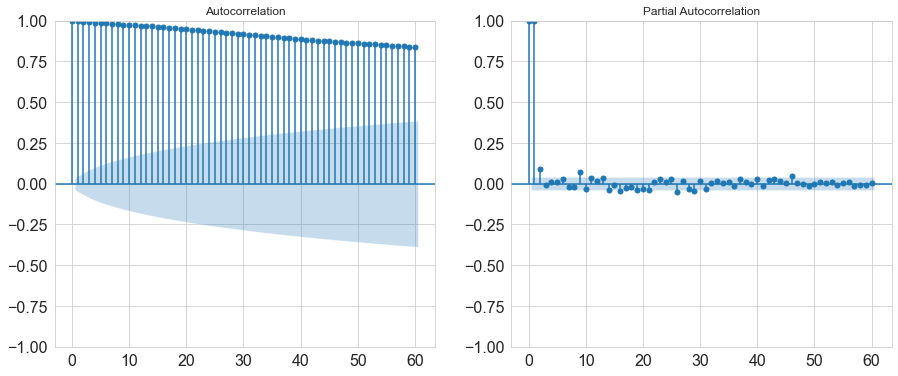

In [46]:
# Creating a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))

# Calculating autocorrelation function (ACF) with 60 lags for Open prices
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

# Plotting the ACF with 60 lags on the first subplot
plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);

# Plotting the partial autocorrelation function (PACF) with 60 lags on the second subplot
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

* For autocorrelation, the y-axis is the value for the correlation between a value and its lag. The lag is on the x-axis. The zero-lag has a correlation of 1 because it correlates with itself perfectly. 
* The autocorrelation plot shows that most of the spikes are not statistically significant. This indicates that the returns are not highly correlated, as shown here.

**<font size="2"><a href="#summary">Back to summary</a></font>**

-----

<div id="chap8"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Lag Scatter Plot</h1></div>

<font color='#5963ab' size='4'>Definition</font>

<br>A scatter plot is a valuable tool for examining the relationship between each observation and its lag. It displays the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line extending from the bottom-left to the top-right of the plot, it indicates a **positive correlation** relationship.
* If the points cluster along a diagonal line extending from the top-left to the bottom-right, it signifies a **negative correlation** relationship.
* Both types of relationships are useful, as they can be modeled.
* The closer the points are to the diagonal line, the stronger the relationship; the more spread out the points are from the line, the weaker the relationship.
* A concentration of points in the center or a dispersion across the plot suggests a weak or non-existent relationship.

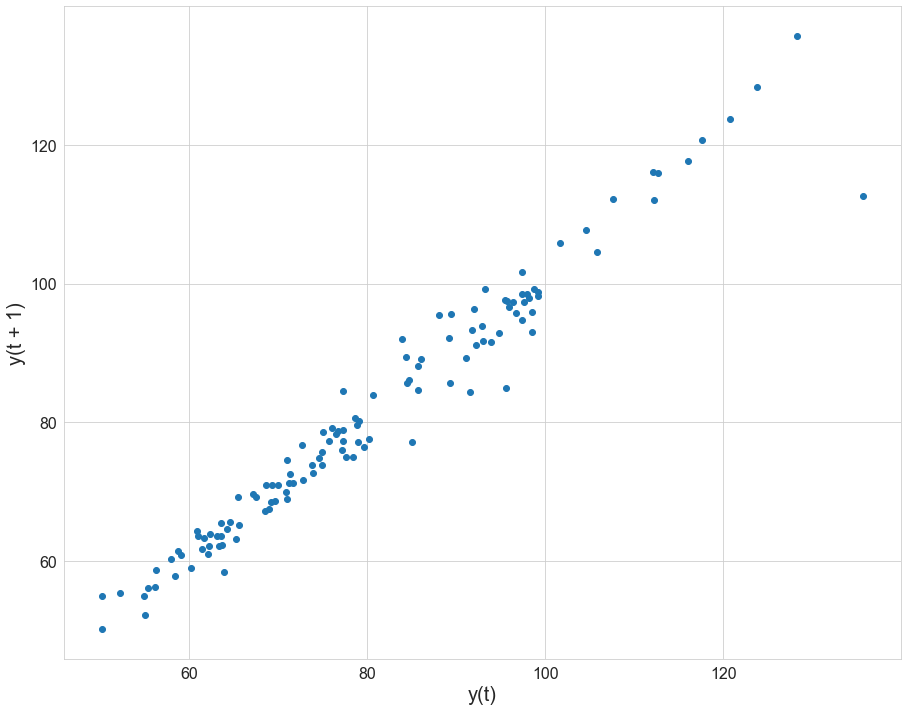

In [47]:
lag_plot(y['Open']);

Here there is a **positive correlation** relationship.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

<div id="chap9"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Moving Average (MA)</h1></div>

<font color='#5963ab' size='4'>The maths behind MA</font>

<br>Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

It can be written as

$$ \hat{T_t} = \frac{1}{m}\sum_{j=-k}^{k}y_{t+j}$$

where $m = 2k + 1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within k periods of $t$.

* Smaller windows will lead to more noise.
* It will always lag by the size of the window.
* It will never reach the full peak or valley of the data due to the averaging.
* It does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew MA significantly.

<AxesSubplot:xlabel='Date'>

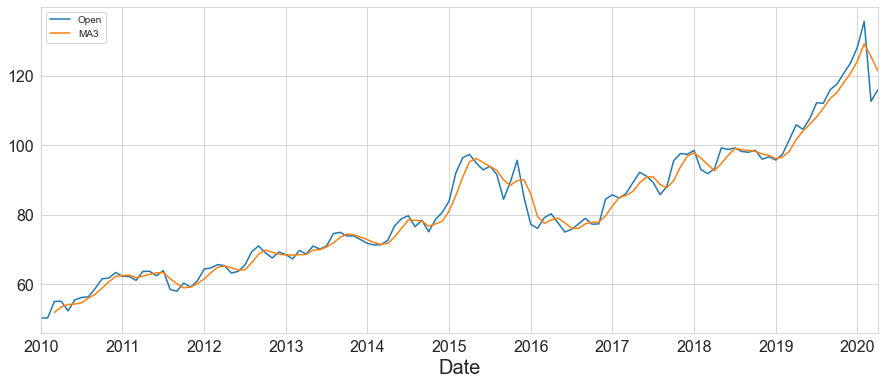

In [48]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Compute rolling mean with window size of 3
y['MA3'] = y.rolling(window=3).mean() 

# Plot the resulting time series
y.plot(figsize=(15,6))

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

<div id="chap10"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Exponential Smoothing</h1></div>

Exponential smoothing assigns **exponentially decreasing weights** for **newest** to **oldest** observations. In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight. Smoothing parameters usually denoted by $\alpha$ ( $0<\alpha\leq1$) determine the weights for observations. Exponential smoothing is usually used to make **short term forecasts**, as longer term forecasts using this technique **can be quite unreliable**.

<AxesSubplot:xlabel='Date'>

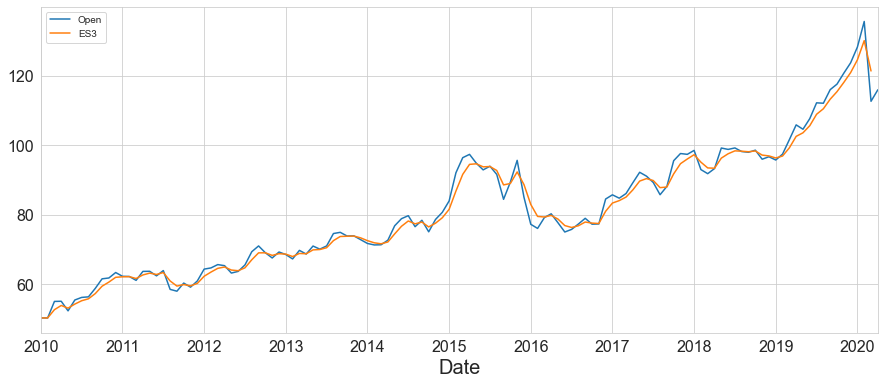

In [49]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
# Fit the model using SimpleExpSmoothing and set smoothing level alpha to alpha
# Shift the fitted values by one time step to plot them against the original data
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

# Plot the original 'Open' values and the Simple exponential smoothing fitted values
y[['Open','ES3']].plot(figsize=(15,6))

<font color='#5963ab' size='4'>Simple, Double, Triple exponential Smoothing ?</font>

<br>**Simple Exponential Smoothing** employs a **weighted moving average with exponentially decreasing weights**.

**Double Exponential Smoothing** adds a second smoothing factor $\beta$ ($0<\beta\leq1$) that addresses trends in the data. The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations. We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an additive adjustment. If the time series displays an exponential (curved) trend, you would use a multiplicative adjustment.

**Triple Exponential Smoothing** (also called the Multiplicative Holt-Winters), the method is usually more reliable for parabolic trends or data that shows trends and seasonality.

<AxesSubplot:xlabel='Date'>

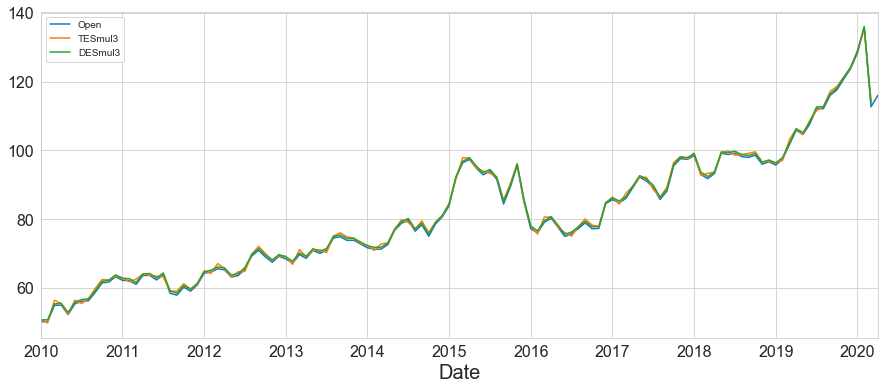

In [50]:
# Plot Double and Triple exponential smoothing

# Double Exponential Smoothing (Holt's Linear Method)
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend='add').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing (Holt-Winters' Method)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

# Plot the original time series and the two smoothed versions
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))

In [56]:
import numpy as np
import pandas as pd

import os
import tensorflow
import keras
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [87]:
# Load csv
df = pd.read_csv('..\lstm\preprocessed_CAC40.csv', parse_dates=['Date'])

In [68]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.

    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [69]:
COMPANY = 'Air Liquide'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [70]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [71]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [72]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [76]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [77]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [93]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.0021
Epoch 1: saving model to weights_best.hdf5
38/38 [==============================] - 2s 45ms/step - loss: 0.0021
Epoch 2/25
37/38 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 2: saving model to weights_best.hdf5
38/38 [==============================] - 2s 45ms/step - loss: 0.0022
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.0020
Epoch 3: saving model to weights_best.hdf5
38/38 [==============================] - 2s 46ms/step - loss: 0.0020
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.0019
Epoch 4: saving model to weights_best.hdf5
38/38 [==============================] - 2s 46ms/step - loss: 0.0019
Epoch 5/25
37/38 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 5: saving model to weights_best.hdf5
38/38 [==============================] - 2s 48ms/step - loss: 0.0021
Epoch 6/25
37/38 [============================>.] - ETA: 0s - los

In [79]:
# Load test data for the specified company and date range
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [80]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 1s 12ms/step


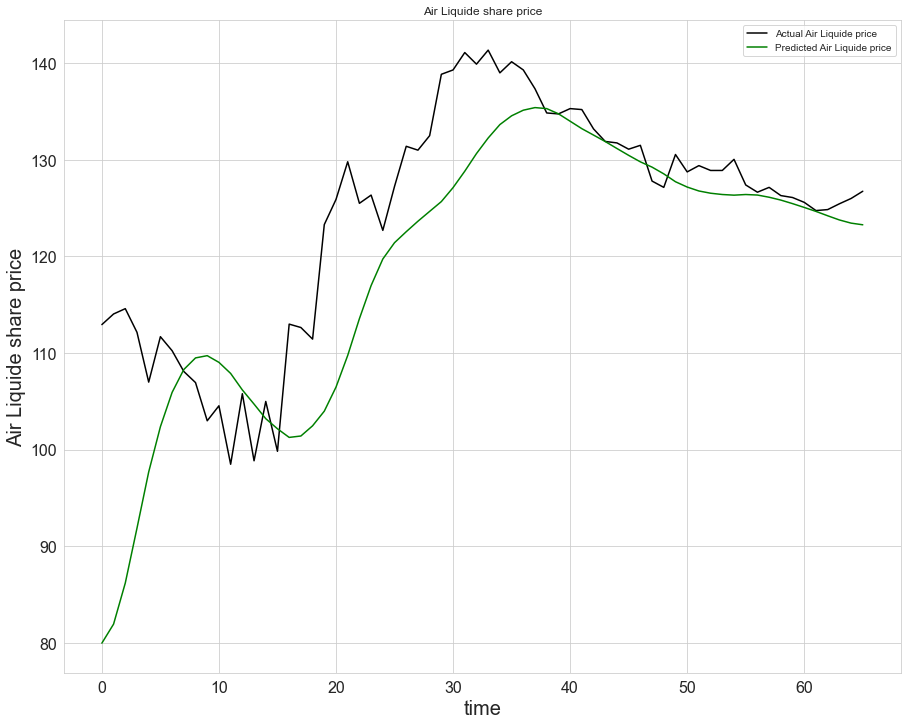

In [81]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [82]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 908ms/step
Prediction: 123.29338073730469
